In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, cholesky
from scipy import io

In [2]:
input_gyro_mat = io.loadmat('/content/drive/MyDrive/Colab Notebooks/kalman_filter/12.EKF/EulerEKF/ArsGyro.mat')
input_accel_mat = io.loadmat('/content/drive/MyDrive/Colab Notebooks/kalman_filter/12.EKF/EulerEKF/ArsAccel.mat')

In [3]:
def get_gyro(i):
    """Measure angular velocity using gyro."""
    p = input_gyro_mat['wx'][i][0]  # input_mat['wx']: (41500, 1)
    q = input_gyro_mat['wy'][i][0]  # input_mat['wy']: (41500, 1)
    r = input_gyro_mat['wz'][i][0]  # input_mat['wz']: (41500, 1)
    return p, q, r

In [4]:
def get_accel(i):
    """Measure angular acceleration using accelerometer (G-meter)."""
    ax = input_accel_mat['fx'][i][0]  # input_mat['fx']: (41500, 1)
    ay = input_accel_mat['fy'][i][0]  # input_mat['fy']: (41500, 1)
    az = input_accel_mat['fz'][i][0]  # input_mat['fz']: (41500, 1)
    return ax, ay, az

In [5]:
def accel2euler(ax, ay, az, phi, the, psi):
    """Calculate Euler angle (Pose Orientation)."""
    g = 9.8  # 9.8 [m/s^2]
    cosThe = np.cos(the)
    phi = np.arcsin(-ay / (g * cosThe))
    the = np.arcsin(ax / g)
    psi = psi
    return phi, the, psi

In [6]:
def sigma_points(mu, Sigma, kappa):
    n = len(mu)
    Xi = np.zeros((n, 2*n+1))
    W = np.zeros(2*n+1)
    
    Xi[:, 0] = mu
    W[0] = kappa / (n + kappa)
    
    U = cholesky((n + kappa)*Sigma)
    
    for i in range(n):
        Xi[:, i+1]   = mu + U[:, i]
        Xi[:, n+i+1] = mu - U[:, i]
        W[i+1]       = 1 / (2*(n+kappa))
        W[n+i+1]     = W[i+1]
        
    return Xi, W

In [7]:
def UT(Xi, W, noiseCov):
    mean = np.sum(W * Xi, axis=1)
    cov = W * (Xi - mean.reshape(-1, 1)) @ (Xi  - mean.reshape(-1, 1)).T
    return mean, cov + noiseCov

In [8]:
def fx(x_esti):
    _, kmax = x_esti.shape
    phi, the, psi = x_esti

    sinPhi = np.sin(phi)
    cosPhi = np.cos(phi)
    tanThe = np.tan(the)
    secThe = 1. / np.cos(the)

    xdot = np.zeros((3, kmax))
    xdot[0, :] = p + q*sinPhi*tanThe + r*cosPhi*tanThe
    xdot[1, :] = q*cosPhi - r*sinPhi
    xdot[2, :] = q*sinPhi*secThe + r*cosPhi*secThe

    x_pred = x_esti + xdot*dt
    return x_pred

def hx(x_pred):
    return H @ x_pred

In [9]:
def unscented_kalman_filter(z_meas, x_esti, P):
    """Unscented Kalman Filter Algorithm."""
    # (1) Sample Sigma Points and Weights.
    Xi, W = sigma_points(x_esti, P, kappa)

    # (2) Predict Mean and Error Covariance of States.
    fXi = fx(Xi)
    x_pred, P_x = UT(fXi, W, Q)

    # (3) Calculate Mean and Error Covariance for the Expected Observation.
    hXi = hx(fXi)
    z_pred, P_z = UT(hXi, W, R)

    # (4) Calculate Off Diagonal Elements of Error Covariance and Kalman Gain.
    Pxz = W * (fXi - x_pred.reshape(-1, 1)) @ (hXi - z_pred.reshape(-1, 1)).T
    K = Pxz @ inv(P_z)

    # (5) Estimate Mean and Error Covariance of States. 
    x_esti = x_pred + K @ (z_meas - z_pred)
    P = P_x - K @ P_z @ K.T

    return x_esti, P

In [10]:
# Input parameters.
n_samples = 41500
dt = 0.01

In [11]:
# Initialization for system model.
# Matrix: A, H, Q, R, P_0
# Vector: x_0
A = np.zeros((3, 3))
H = np.eye(3)
Q = np.array([[0.0001, 0, 0],
              [0, 0.0001, 0],
              [0, 0, 1]])
R = 10 * np.eye(3)

# Initialization for estimation.
x_0 = np.zeros(3)  # (phi, the, psi) by my definition.
P_0 = 1 * np.eye(3)

# Initialization for sigma points.
kappa = 0

In [12]:
time = np.arange(n_samples) * dt
phi_esti_save = np.zeros(n_samples)
the_esti_save = np.zeros(n_samples)
psi_esti_save = np.zeros(n_samples)

In [13]:
phi, the, psi = 0, 0, 0
x_esti, P = None, None
for i in range(n_samples):
    p, q, r = get_gyro(i)
    ax, ay, az = get_accel(i)
    phi, the, psi = accel2euler(ax, ay, az, phi, the, psi)
    z_meas = np.array([phi, the, psi])

    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = unscented_kalman_filter(z_meas, x_esti, P)

    phi_esti_save[i] = np.rad2deg(x_esti[0])
    the_esti_save[i] = np.rad2deg(x_esti[1])
    psi_esti_save[i] = np.rad2deg(x_esti[2])

Text(0, 0.5, 'Pitch ($\\theta$) angle [deg]')

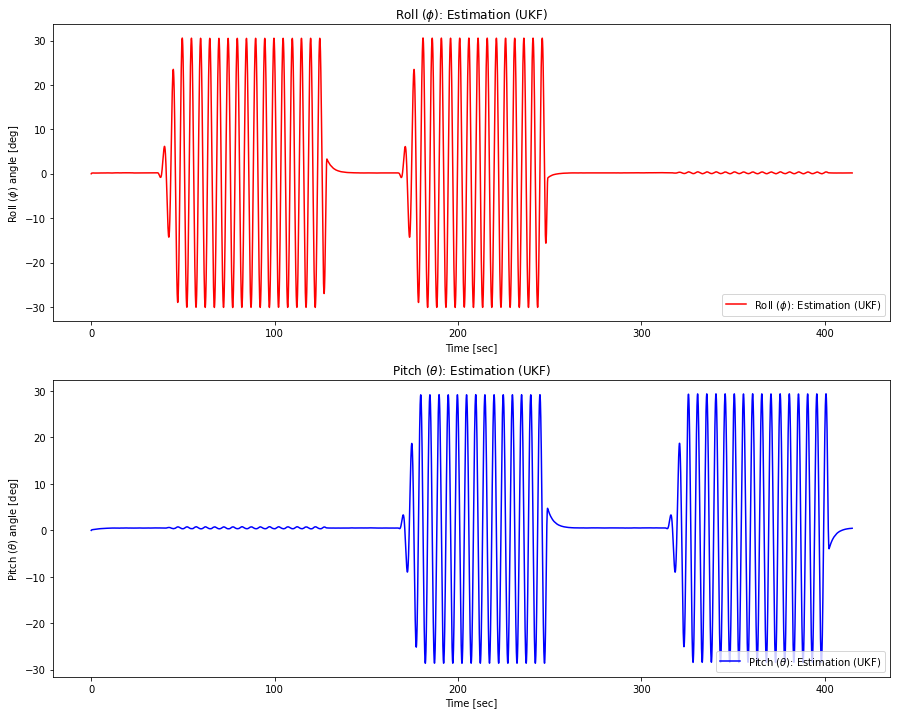

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

axes[0].plot(time, phi_esti_save, 'r', label='Roll ($\\phi$): Estimation (UKF)', markersize=0.2)
axes[0].legend(loc='lower right')
axes[0].set_title('Roll ($\\phi$): Estimation (UKF)')
axes[0].set_xlabel('Time [sec]')
axes[0].set_ylabel('Roll ($\phi$) angle [deg]')

axes[1].plot(time, the_esti_save, 'b', label='Pitch ($\\theta$): Estimation (UKF)', markersize=0.2)
axes[1].legend(loc='lower right')
axes[1].set_title('Pitch ($\\theta$): Estimation (UKF)')
axes[1].set_xlabel('Time [sec]')
axes[1].set_ylabel('Pitch ($\\theta$) angle [deg]')